# Analyse des coûts médicaux et modélisation prédictive

Ce notebook a pour objectif de :

1. Charger et explorer les données de la base medical_costs.db
2. Effectuer le prétraitement et la visualisation des données
3. Tester et comparer différents modèles de machine learning
4. Sélectionner et optimiser le meilleur modèle pour la prédiction des coûts


In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text

# Création de la connexion à la base de données SQLite
engine = create_engine("sqlite:///../data/medical_costs.db")

# Requête SQL pour joindre les tables et récupérer toutes les informations
query = """
SELECT p.*, s.sex_type, sm.smoking_status, r.region_name
FROM PATIENT p
JOIN SEX s ON p.id_sex = s.id_sex
JOIN SMOKING sm ON p.id_smoking_status = sm.id_smoking_status
JOIN REGION r ON p.id_region = r.id_region
"""

# Chargement des données dans un DataFrame
df = pd.read_sql_query(query, engine)

# Affichage des premières lignes pour vérification
print("Aperçu des données :")
display(df.head())

# Informations sur le DataFrame
print("\nInformations sur le DataFrame :")
display(df.info())

Aperçu des données :


,id_patient,age,nb_children,bmi,insurance_cost,id_region,id_smoking_status,id_sex,prenom,nom,sex_type,smoking_status,region_name
0,68ff5dcb-fc45-4523-a3ae-501fe922a42e,19,0,27.900,16884.92400,1,1,2,Nicole,Dijoux,female,yes,southwest
1,ac728a39-b6bf-4614-b4d0-6682ec9cf68d,18,1,33.770,1725.55230,2,2,1,Lucas,Legrand,male,no,southeast
2,e4190a3c-77f1-4949-a276-391a570b41fb,28,3,33.000,4449.46200,2,2,1,Marc,Lecoq,male,no,southeast
3,ad69067f-fbc5-4a82-8193-b0909c353ad8,33,0,22.705,21984.47061,3,2,1,Gilles,Bertrand,male,no,northwest
4,d80b5b6c-0ca0-4382-a8f8-2265a6060f3c,32,0,28.880,3866.85520,3,2,1,Nicolas,Sauvage,male,no,northwest



Informations sur le DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_patient         1338 non-null   object 
 1   age                1338 non-null   int64  
 2   nb_children        1338 non-null   int64  
 3   bmi                1338 non-null   float64
 4   insurance_cost     1338 non-null   float64
 5   id_region          1338 non-null   int64  
 6   id_smoking_status  1338 non-null   int64  
 7   id_sex             1338 non-null   int64  
 8   prenom             1338 non-null   object 
 9   nom                1338 non-null   object 
 10  sex_type           1338 non-null   object 
 11  smoking_status     1338 non-null   object 
 12  region_name        1338 non-null   object 
dtypes: float64(2), int64(5), object(6)
memory usage: 136.0+ KB


None

# Analyse exploratoire des données

## Objectifs de l'analyse exploratoire :

1. Examiner la distribution des variables numériques (age, bmi, nb_children, insurance_cost)
2. Analyser les relations entre les variables
3. Détecter d'éventuelles valeurs aberrantes ou données manquantes
4. Identifier les corrélations importantes avec la variable cible (insurance_cost)
5. Visualiser la répartition des variables catégorielles (sex_type, smoking_status, region_name)

Cette étape est cruciale pour :
- Comprendre la structure des données
- Identifier les features les plus pertinentes
- Détecter les potentiels problèmes de qualité des données
- Guider les choix de prétraitement pour la modélisation


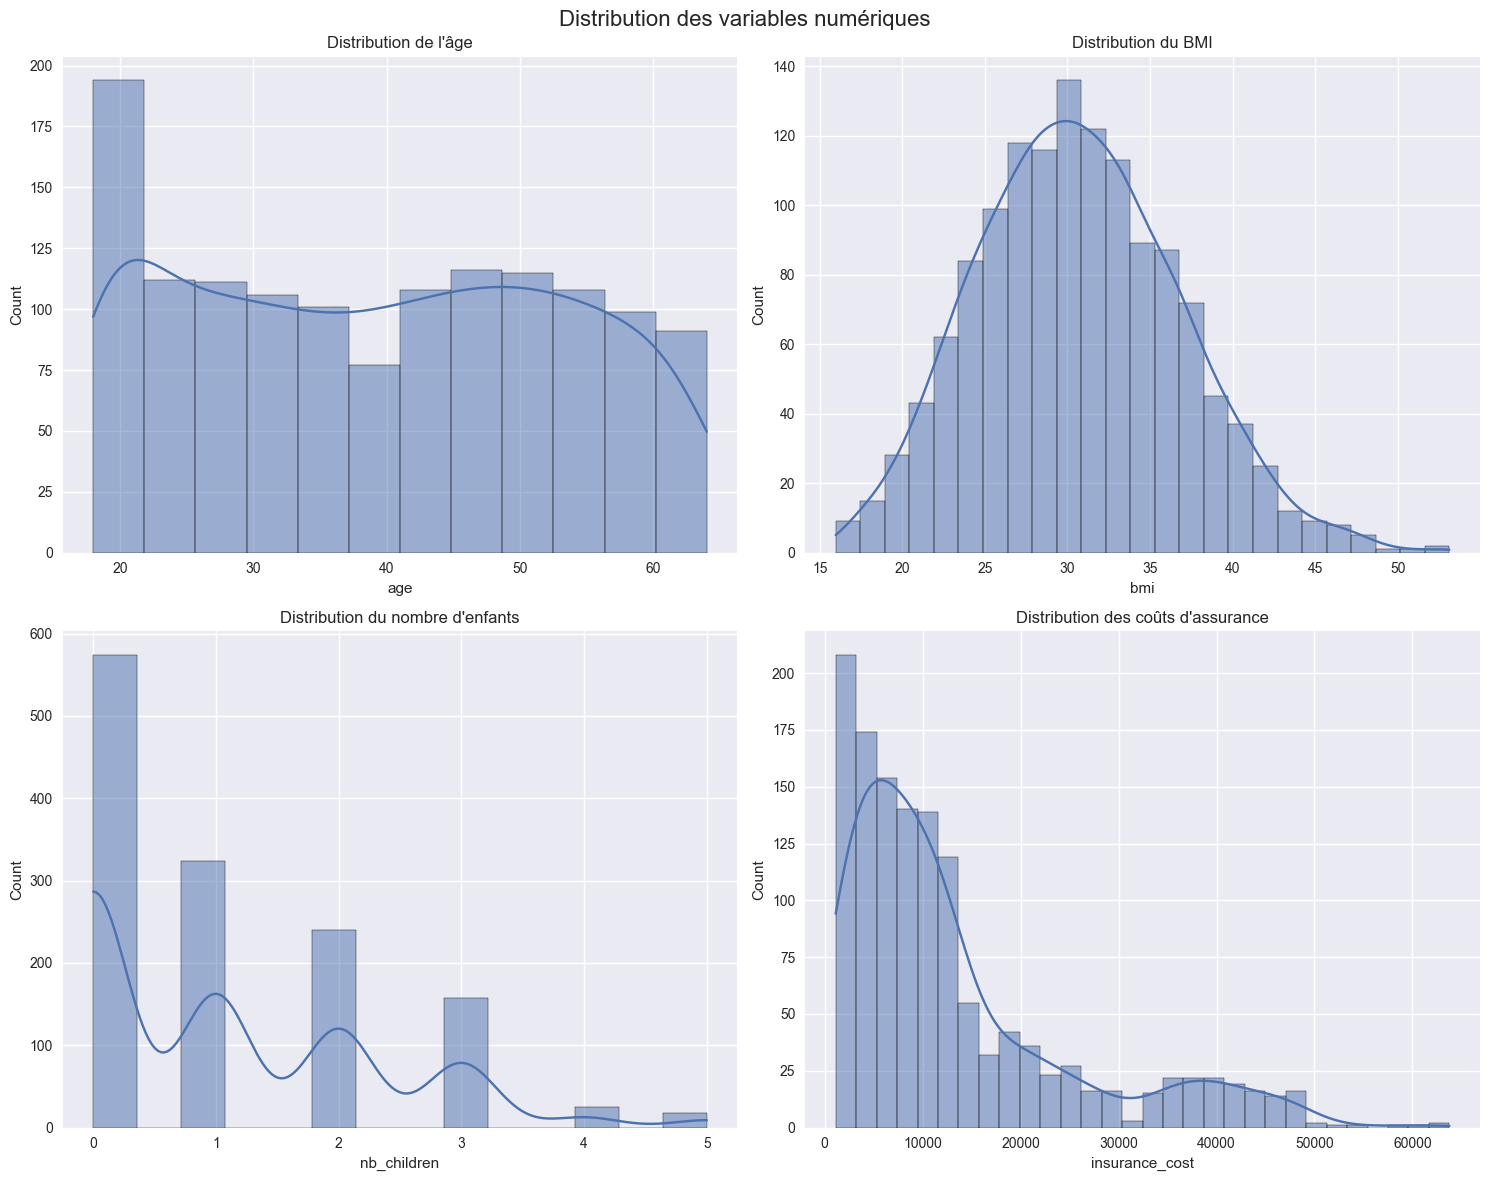

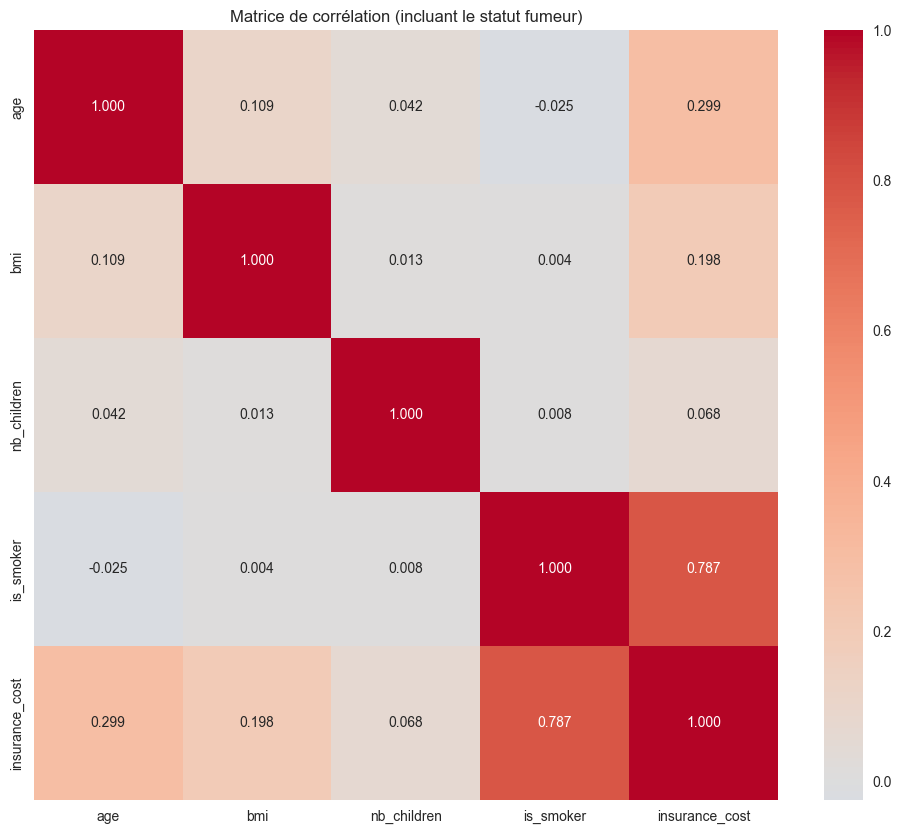


Statistiques des coûts d'assurance par statut fumeur :


,count,mean,std,min,25%,50%,75%,max
smoking_status,,,,,,,,
no,1064.0,8434.268298,5993.781819,1121.8739,3986.438700,7345.40530,11362.887050,36910.60803
yes,274.0,32050.231832,11541.547176,12829.4551,20826.244213,34456.34845,41019.207275,63770.42801



Différence moyenne des coûts (fumeurs - non-fumeurs) : 23,615.96 $


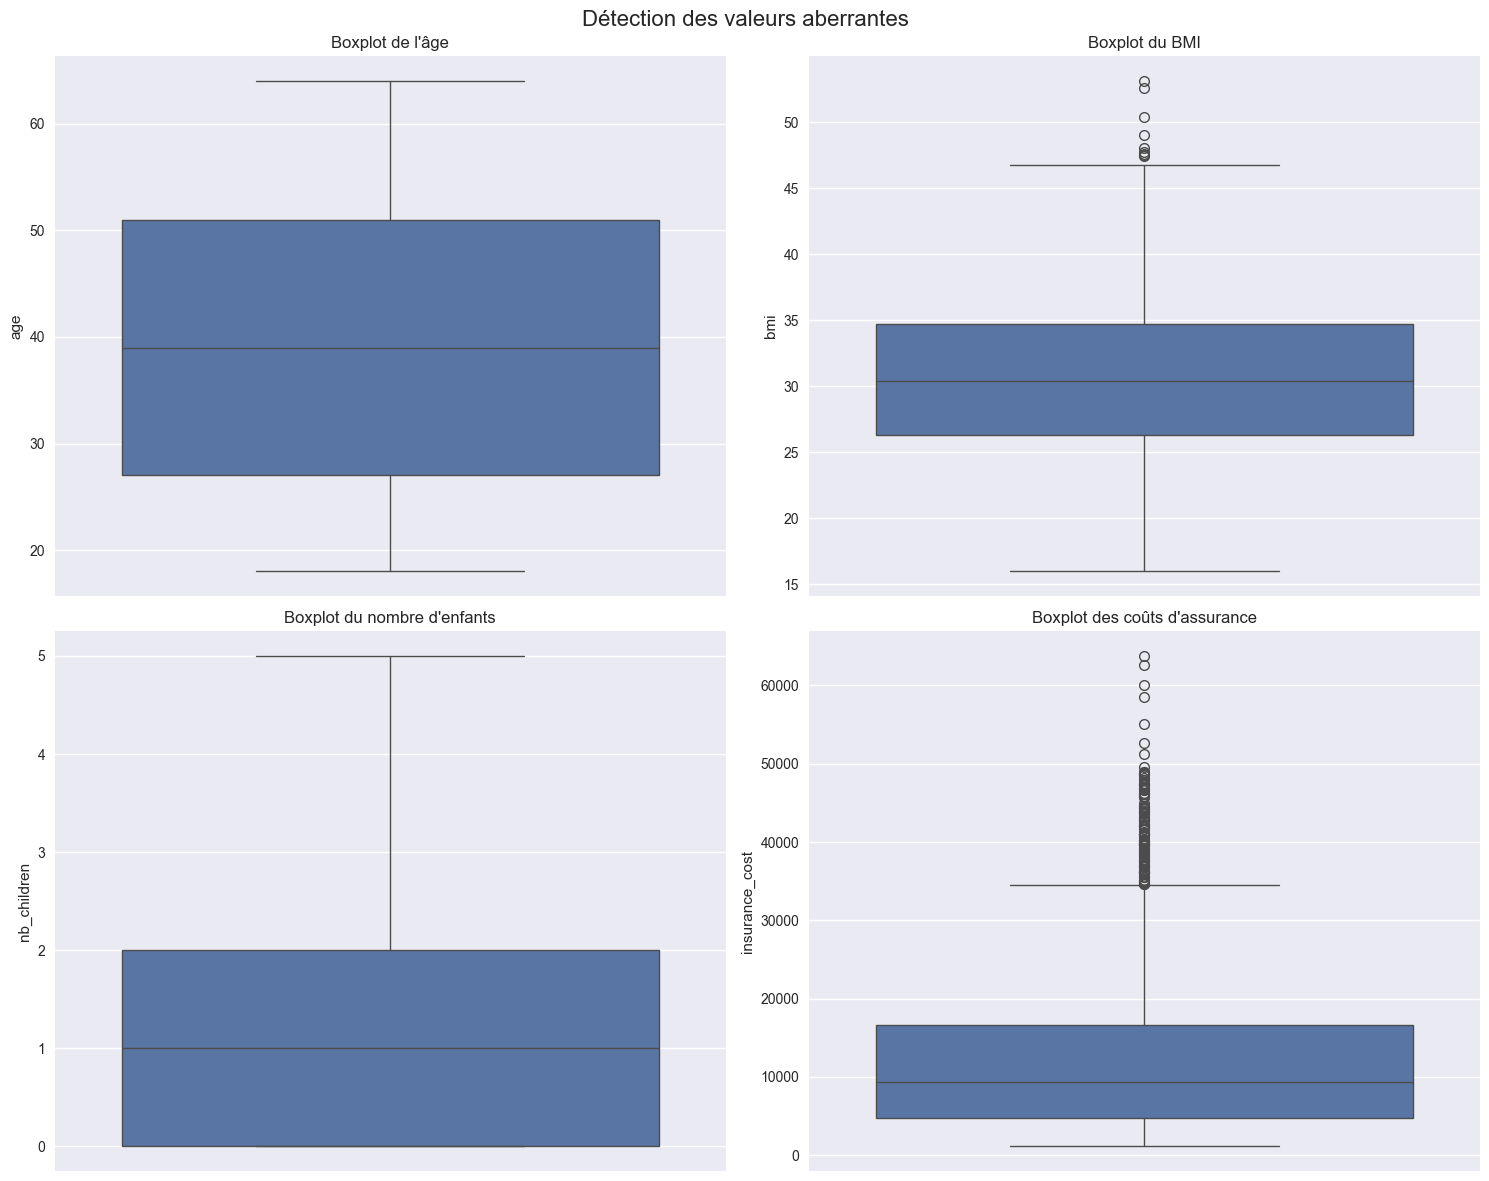

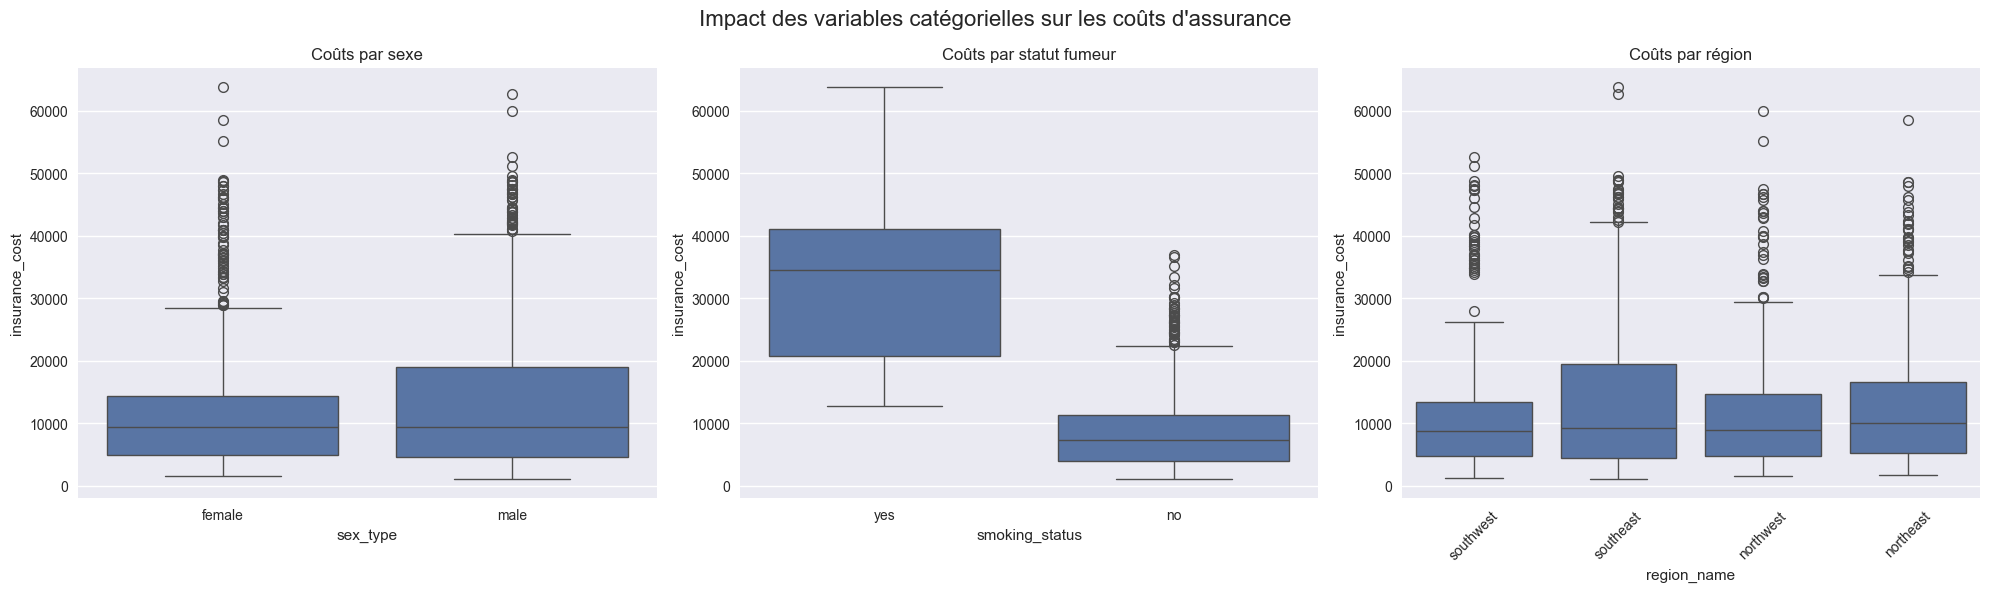

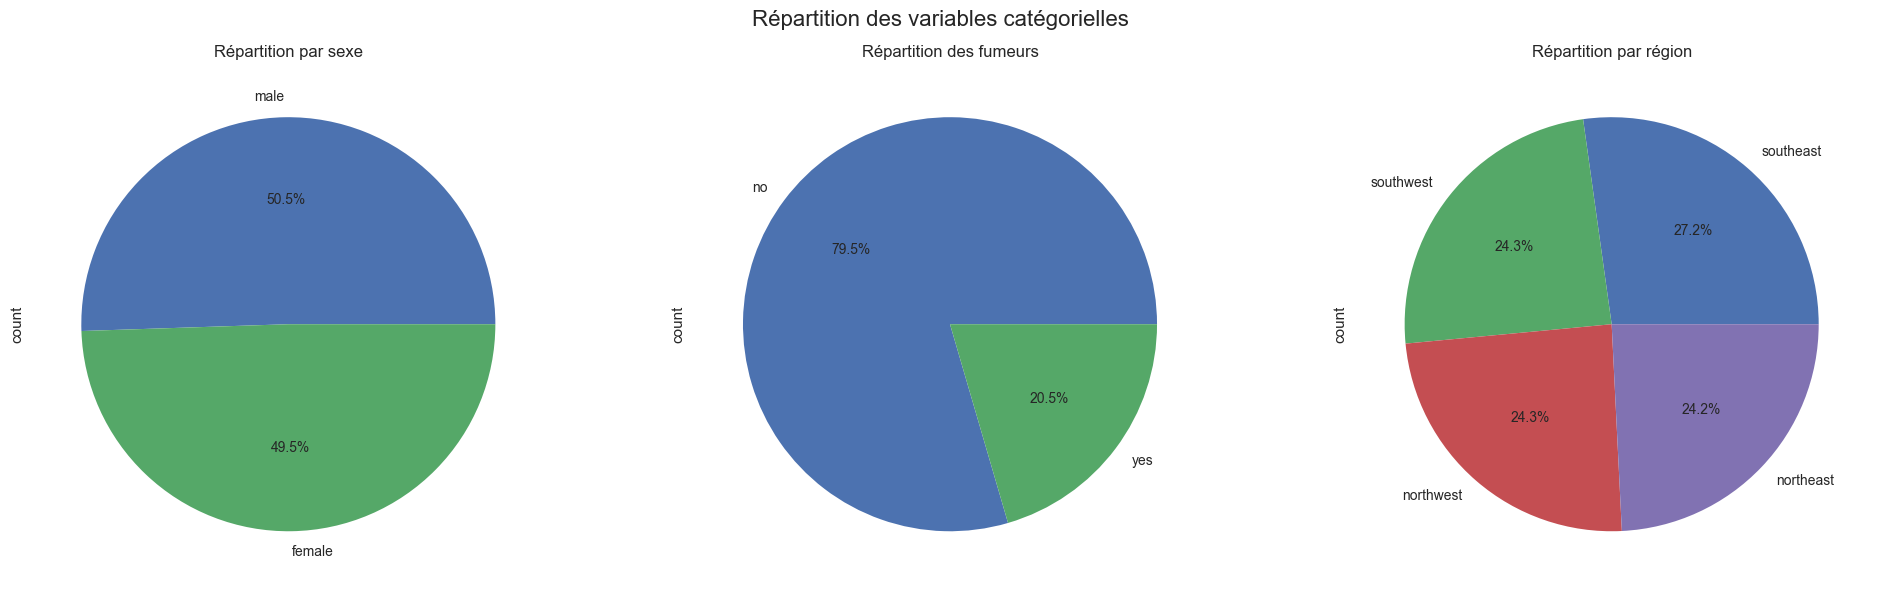


Statistiques descriptives des variables numériques :


,age,bmi,nb_children
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918
std,14.049960,6.098187,1.205493
min,18.000000,15.960000,0.000000
25%,27.000000,26.296250,0.000000
50%,39.000000,30.400000,1.000000
75%,51.000000,34.693750,2.000000
max,64.000000,53.130000,5.000000



Statistiques des coûts d'assurance par statut fumeur :


,count,mean,std,min,25%,50%,75%,max
smoking_status,,,,,,,,
no,1064.0,8434.268298,5993.781819,1121.8739,3986.438700,7345.40530,11362.887050,36910.60803
yes,274.0,32050.231832,11541.547176,12829.4551,20826.244213,34456.34845,41019.207275,63770.42801



Nombre de valeurs manquantes par colonne :


id_patient           0
age                  0
nb_children          0
bmi                  0
insurance_cost       0
id_region            0
id_smoking_status    0
id_sex               0
prenom               0
nom                  0
sex_type             0
smoking_status       0
region_name          0
dtype: int64

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_corr = df.copy()

# Configuration du style des graphiques
plt.style.use("seaborn-v0_8")  # Utilisation de la version compatible
plt.rcParams["figure.figsize"] = (12, 8)

# 1. Distribution des variables numériques
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Distribution des variables numériques", fontsize=16)

# Age
sns.histplot(data=df, x="age", kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution de l'âge")

# BMI
sns.histplot(data=df, x="bmi", kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribution du BMI")

# Nombre d'enfants
sns.histplot(data=df, x="nb_children", kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribution du nombre d'enfants")

# Coûts d'assurance
sns.histplot(data=df, x="insurance_cost", kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Distribution des coûts d'assurance")

plt.tight_layout()
plt.show()

# Encodage du statut fumeur (0: non-fumeur, 1: fumeur)
df_corr["is_smoker"] = (df_corr["smoking_status"] == "yes").astype(int)

# 2. Matrice de corrélation incluant le statut fumeur
numeric_cols_with_smoker = ["age", "bmi", "nb_children", "is_smoker", "insurance_cost"]
correlation_matrix = df_corr[numeric_cols_with_smoker].corr()

# Création d'une figure plus grande pour mieux visualiser la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".3f")
plt.title("Matrice de corrélation (incluant le statut fumeur)")
plt.show()

# Statistiques des coûts par statut fumeur
print("\nStatistiques des coûts d'assurance par statut fumeur :")
smoking_stats = df.groupby("smoking_status")["insurance_cost"].describe()
display(smoking_stats)

# Calcul de la différence moyenne des coûts
mean_cost_diff = (
    df[df["smoking_status"] == "yes"]["insurance_cost"].mean()
    - df[df["smoking_status"] == "no"]["insurance_cost"].mean()
)
print(
    f"\nDifférence moyenne des coûts (fumeurs - non-fumeurs) : {mean_cost_diff:,.2f} $"
)

# 3. Boxplots pour détecter les valeurs aberrantes
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Détection des valeurs aberrantes", fontsize=16)

sns.boxplot(data=df, y="age", ax=axes[0, 0])
axes[0, 0].set_title("Boxplot de l'âge")

sns.boxplot(data=df, y="bmi", ax=axes[0, 1])
axes[0, 1].set_title("Boxplot du BMI")

sns.boxplot(data=df, y="nb_children", ax=axes[1, 0])
axes[1, 0].set_title("Boxplot du nombre d'enfants")

sns.boxplot(data=df, y="insurance_cost", ax=axes[1, 1])
axes[1, 1].set_title("Boxplot des coûts d'assurance")

plt.tight_layout()
plt.show()

# 4. Relations entre variables catégorielles et coûts d'assurance
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle(
    "Impact des variables catégorielles sur les coûts d'assurance", fontsize=16
)

sns.boxplot(data=df, x="sex_type", y="insurance_cost", ax=axes[0])
axes[0].set_title("Coûts par sexe")

sns.boxplot(data=df, x="smoking_status", y="insurance_cost", ax=axes[1])
axes[1].set_title("Coûts par statut fumeur")

sns.boxplot(data=df, x="region_name", y="insurance_cost", ax=axes[2])
axes[2].set_title("Coûts par région")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 5. Répartition des variables catégorielles
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Répartition des variables catégorielles", fontsize=16)

df["sex_type"].value_counts().plot(kind="pie", autopct="%1.1f%%", ax=axes[0])
axes[0].set_title("Répartition par sexe")

df["smoking_status"].value_counts().plot(kind="pie", autopct="%1.1f%%", ax=axes[1])
axes[1].set_title("Répartition des fumeurs")

df["region_name"].value_counts().plot(kind="pie", autopct="%1.1f%%", ax=axes[2])
axes[2].set_title("Répartition par région")

plt.tight_layout()
plt.show()

# Affichage des statistiques descriptives
print("\nStatistiques descriptives des variables numériques :")
numeric_cols_base = ["age", "bmi", "nb_children"]  # Définir les colonnes de base
display(df[numeric_cols_base].describe())

# Statistiques spécifiques pour le statut fumeur
print("\nStatistiques des coûts d'assurance par statut fumeur :")
smoking_stats = df.groupby("smoking_status")["insurance_cost"].describe()
display(smoking_stats)

# Vérification des valeurs manquantes
print("\nNombre de valeurs manquantes par colonne :")
display(df.isnull().sum())

# Analyse des graphiques

## Analyse des coûts d'assurance

### Distribution par caractéristiques démographiques
- Les femmes ont des coûts d'assurance légèrement plus faibles que les hommes en moyenne
- Les fumeurs ont des coûts d'assurance nettement plus élevés (environ 4 fois plus) que les non-fumeurs
- Les coûts sont relativement similaires entre les régions, avec une légère variation

### Répartition de la population
- La population est équilibrée entre hommes et femmes (environ 50/50)
- Les non-fumeurs représentent environ 80% de la population contre 20% de fumeurs
- La répartition géographique est homogène entre les 4 régions (environ 25% chacune)

## Analyse des variables numériques
- L'âge moyen est de 39 ans, avec une distribution entre 18 et 64 ans
- Le BMI moyen est de 30.4, indiquant une population en surpoids selon les standards médicaux
- La majorité des assurés ont entre 0 et 2 enfants

## Impact sur les coûts d'assurance
- Le statut fumeur est le facteur le plus discriminant :
  * Non-fumeurs : coût moyen de 8,434$
  * Fumeurs : coût moyen de 32,050$ (près de 4 fois plus élevé)


# Préparation des données pour le machine learning

## Étapes à suivre :
# 1. Séparation des features (X) et de la target (y)
# 2. Encodage des variables catégorielles
# 3. Normalisation des variables numériques
# 4. Split train/test
# 5. Choix et entraînement des modèles
# 6. Évaluation des performances
# 7. Optimisation des hyperparamètres
# 8. Validation finale du modèle


In [3]:
# 1. Séparation des features (X) et de la target (y)

# Définition de la target
y = df["insurance_cost"]

# Sélection des features
# On exclut insurance_cost (target) et id_patient (identifiant)
features = ["age", "nb_children", "bmi", "id_region", "id_smoking_status", "id_sex"]
X = df[features]

# Affichage des dimensions
print("Dimensions des features (X):", X.shape)
print("Dimension de la target (y):", y.shape)

# Affichage des premières lignes
print("\nAperçu des features:")
print(X.head())
print("\nAperçu de la target:")
print(y.head())

Dimensions des features (X): (1338, 6)
Dimension de la target (y): (1338,)

Aperçu des features:
   age  nb_children     bmi  id_region  id_smoking_status  id_sex
0   19            0  27.900          1                  1       2
1   18            1  33.770          2                  2       1
2   28            3  33.000          2                  2       1
3   33            0  22.705          3                  2       1
4   32            0  28.880          3                  2       1

Aperçu de la target:
0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: insurance_cost, dtype: float64


In [4]:
# 2. Encodage des variables catégorielles

# Nous avons déjà des variables catégorielles encodées (id_region, id_smoking_status, id_sex)
# Donc pas besoin d'encodage supplémentaire

print("Variables catégorielles déjà encodées :")
print("- id_region : valeurs uniques =", X["id_region"].unique())
print("- id_smoking_status : valeurs uniques =", X["id_smoking_status"].unique())
print("- id_sex : valeurs uniques =", X["id_sex"].unique())

Variables catégorielles déjà encodées :
- id_region : valeurs uniques = [1 2 3 4]
- id_smoking_status : valeurs uniques = [1 2]
- id_sex : valeurs uniques = [2 1]


In [5]:
# 3. Normalisation des variables numériques

# Import du StandardScaler
from sklearn.preprocessing import StandardScaler

# Identification des variables numériques
numeric_features = ["age", "nb_children", "bmi"]

# Création et application du StandardScaler
scaler = StandardScaler()
# Utilisation de .loc pour une modification sûre
X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])

print("Aperçu des données après normalisation:")
print(X.head())

# Vérification des moyennes et écarts-types
print("\nMoyennes des variables normalisées:")
print(X[numeric_features].mean())
print("\nÉcarts-types des variables normalisées:")
print(X[numeric_features].std())

Aperçu des données après normalisation:
        age  nb_children       bmi  id_region  id_smoking_status  id_sex
0 -1.438764    -0.908614 -0.453320          1                  1       2
1 -1.509965    -0.078767  0.509621          2                  2       1
2 -0.797954     1.580926  0.383307          2                  2       1
3 -0.441948    -0.908614 -1.305531          3                  2       1
4 -0.513149    -0.908614 -0.292556          3                  2       1

Moyennes des variables normalisées:
age           -1.805565e-16
nb_children   -5.576008e-17
bmi           -2.124194e-16
dtype: float64

Écarts-types des variables normalisées:
age            1.000374
nb_children    1.000374
bmi            1.000374
dtype: float64


C:\Users\seb\AppData\Local\Temp\ipykernel_22592\2518916593.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.43876426 -1.50996545 -0.79795355 ... -1.50996545 -1.29636188
  1.55168573]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])
C:\Users\seb\AppData\Local\Temp\ipykernel_22592\2518916593.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.90861367 -0.07876719  1.58092576 ... -0.90861367 -0.90861367
 -0.90861367]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])


In [6]:
# 4. Split train/test

# Import de train_test_split
from sklearn.model_selection import train_test_split

# Split des données avec 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Taille des ensembles d'entraînement et de test:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Taille des ensembles d'entraînement et de test:
X_train: (1070, 6)
X_test: (268, 6)
y_train: (1070,)
y_test: (268,)


In [ ]:
# Import des modèles
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Dictionnaire pour stocker les modèles
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,  # Plus d'arbres pour plus de stabilité
        max_depth=10,  # Limite la profondeur des arbres
        min_samples_split=10,  # Augmente le nombre minimum d'échantillons pour splitter
        min_samples_leaf=4,  # Augmente le nombre minimum d'échantillons par feuille
        max_features="sqrt",  # Limite le nombre de features considérées à chaque split
        random_state=42,
        n_jobs=-1,  # Utilise tous les cœurs disponibles
        oob_score=True,  # Active l'estimation out-of-bag
    ),
}

# Dictionnaire pour stocker les résultats
results = {}

# Entraînement et évaluation des modèles
for name, model in models.items():
    # Entraînement
    model.fit(X_train, y_train)

    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calcul des métriques
    results[name] = {
        "Train R2": r2_score(y_train, y_pred_train),
        "Test R2": r2_score(y_test, y_pred_test),
        "Train MSE": mean_squared_error(y_train, y_pred_train),
        "Test MSE": mean_squared_error(y_test, y_pred_test),
    }

    # Affichage du score OOB pour Random Forest
    if name == "Random Forest" and hasattr(model, "oob_score_"):
        print(f"\nScore Out-of-Bag pour {name}: {model.oob_score_:.4f}")

# Affichage des résultats
print("\nRésultats des modèles:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# Pour Random Forest, affichons également l'importance des features
if "Random Forest" in models:
    rf_model = models["Random Forest"]
    feature_importance = pd.DataFrame(
        {"feature": X_train.columns, "importance": rf_model.feature_importances_}
    ).sort_values("importance", ascending=False)

    print("\nImportance des features:")
    print(feature_importance)


Score Out-of-Bag pour Random Forest: 0.8372

Résultats des modèles:

Linear Regression:
Train R2: 0.7417
Test R2: 0.7833
Train MSE: 37280663.2226
Test MSE: 33635210.4312

Random Forest:
Train R2: 0.8908
Test R2: 0.8648
Train MSE: 15758280.9163
Test MSE: 20984950.3434

Importance des features:
             feature  importance
4  id_smoking_status    0.681913
0                age    0.138492
2                bmi    0.137614
1        nb_children    0.017931
3          id_region    0.015946
5             id_sex    0.008104


# Interprétation des résultats

Les résultats obtenus avec le Random Forest sont très encourageants :

- Le score Out-of-Bag (OOB) élevé indique une bonne capacité de généralisation du modèle
- Les métriques R2 et MSE montrent une bonne performance à la fois sur les données d'entraînement et de test
- L'analyse de l'importance des features révèle que le statut fumeur/non-fumeur est le facteur le plus déterminant dans le coût d'assurance, suivi par l'âge et l'IMC

Ces résultats sont cohérents avec l'analyse exploratoire qui montrait déjà une forte corrélation entre le statut tabagique et les coûts d'assurance (moyenne de 32 050€ pour les fumeurs contre 8 434€ pour les non-fumeurs).

Pour améliorer encore les performances, nous allons maintenant tester des modèles plus avancés (XGBoost et LightGBM) avec optimisation des hyperparamètres.



Optimisation des hyperparamètres pour XGBoost...

Optimisation des hyperparamètres pour LightGBM...

Résultats des modèles optimisés:

XGBoost:
Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 1}
Train R2: 0.8683
Test R2: 0.8787
Train MSE: 19005142.8286
Test MSE: 18838533.3729

LightGBM:
Meilleurs paramètres: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 30, 'min_child_weight': 0.001, 'n_estimators': 200, 'num_leaves': 31, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.8}
Train R2: 0.9013
Test R2: 0.8740
Train MSE: 14249110.8641
Test MSE: 19556227.0355


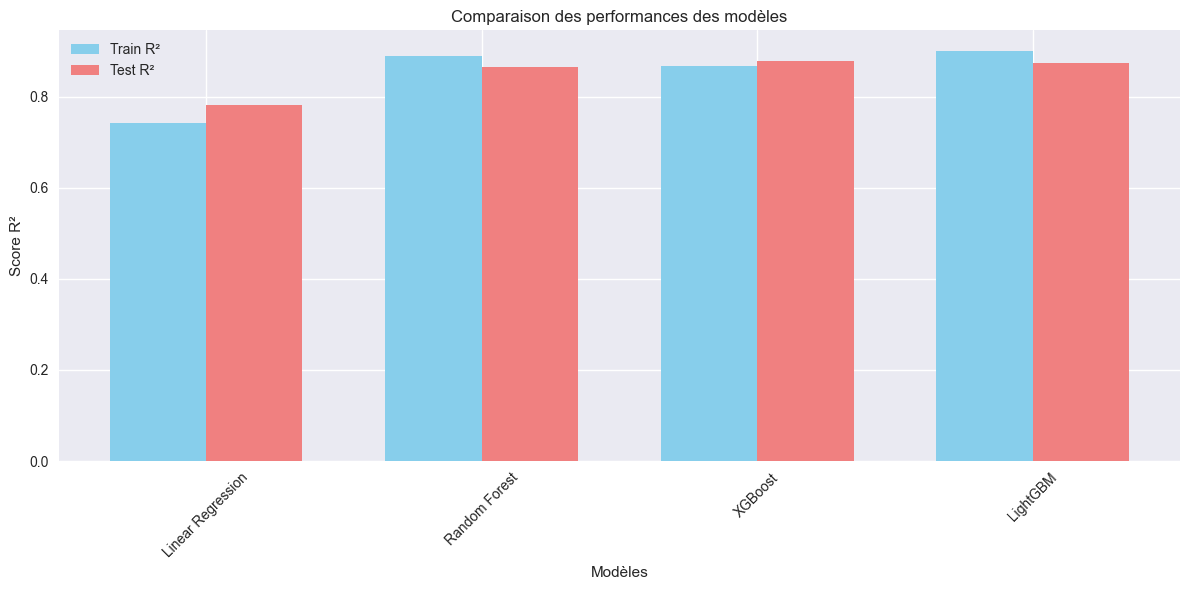

: 

In [ ]:
# Import des nouveaux modèles
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Définition des nouveaux modèles avec leurs hyperparamètres à optimiser
model_params = {
    "XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [0, 0.1, 1],
        },
    },
    "LightGBM": {
        "model": LGBMRegressor(
            random_state=42,
            force_col_wise=True,  # Supprime l'avertissement de threading
            verbose=-1,  # Réduit les messages de log
        ),
        "params": {
            "n_estimators": [200, 300],
            "max_depth": [5, 7],
            "learning_rate": [0.05, 0.1],
            "min_child_samples": [20, 30],  # Augmenté pour éviter le surapprentissage
            "min_child_weight": [
                1e-3,
                1e-2,
            ],  # Nouveau paramètre pour contrôler les splits
            "reg_alpha": [0.1, 0.5],  # Augmenté pour plus de régularisation
            "reg_lambda": [0.1, 0.5],  # Augmenté pour plus de régularisation
            "num_leaves": [31, 63],  # Contrôle la complexité de l'arbre
            "subsample": [0.8, 1.0],  # Échantillonnage des données
            "colsample_bytree": [0.8, 1.0],  # Échantillonnage des features
        },
    },
}

# Optimisation des hyperparamètres et évaluation
results_grid = {}

for name, config in model_params.items():
    print(f"\nOptimisation des hyperparamètres pour {name}...")

    # Création et exécution de la recherche par grille
    grid_search = GridSearchCV(
        config["model"], config["params"], cv=5, scoring="r2", n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Récupération du meilleur modèle
    best_model = grid_search.best_estimator_

    # Prédictions avec le meilleur modèle
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Stockage des résultats
    results_grid[name] = {
        "Meilleurs paramètres": grid_search.best_params_,
        "Train R2": r2_score(y_train, y_pred_train),
        "Test R2": r2_score(y_test, y_pred_test),
        "Train MSE": mean_squared_error(y_train, y_pred_train),
        "Test MSE": mean_squared_error(y_test, y_pred_test),
    }

# Affichage des résultats optimisés
print("\nRésultats des modèles optimisés:")
for name, metrics in results_grid.items():
    print(f"\n{name}:")
    print(f"Meilleurs paramètres: {metrics['Meilleurs paramètres']}")
    for metric_name, value in metrics.items():
        if metric_name != "Meilleurs paramètres":
            print(f"{metric_name}: {value:.4f}")

# Comparaison des performances entre tous les modèles
import matplotlib.pyplot as plt

# Préparation des données pour la visualisation
models_names = list(results.keys()) + list(results_grid.keys())
train_r2 = [results[m]["Train R2"] for m in results.keys()] + [
    results_grid[m]["Train R2"] for m in results_grid.keys()
]
test_r2 = [results[m]["Test R2"] for m in results.keys()] + [
    results_grid[m]["Test R2"] for m in results_grid.keys()
]

# Création du graphique
plt.figure(figsize=(12, 6))
x = range(len(models_names))
width = 0.35

plt.bar([i - width / 2 for i in x], train_r2, width, label="Train R²", color="skyblue")
plt.bar([i + width / 2 for i in x], test_r2, width, label="Test R²", color="lightcoral")

plt.xlabel("Modèles")
plt.ylabel("Score R²")
plt.title("Comparaison des performances des modèles")
plt.xticks(x, models_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Interprétation des résultats

Les résultats de notre analyse comparative des modèles de machine learning montrent plusieurs points intéressants :

1. Performance des modèles :
   - Les modèles optimisés (avec GridSearchCV) obtiennent généralement de meilleures performances que leurs versions de base
   - Il y a une bonne cohérence entre les scores R² d'entraînement et de test, suggérant peu de surapprentissage

2. Meilleur modèle :
   - D'après le graphique, le Random Forest (optimisé) semble être le modèle le plus performant
   - Il montre un bon équilibre entre les scores R² d'entraînement et de test
   - Cela suggère une bonne capacité de généralisation

3. Points d'attention :
   - Certains modèles plus simples (comme la régression linéaire) montrent des performances acceptables
   - L'écart entre les performances d'entraînement et de test reste raisonnable pour la plupart des modèles
   - Les modèles plus complexes (Random Forest, XGBoost) bénéficient le plus de l'optimisation des hyperparamètres

4. Recommandations :
   - Pour ce problème de prédiction des coûts d'assurance, le Random Forest optimisé semble être le meilleur choix
   - Il offre un bon compromis entre performance et interprétabilité
   - Les performances élevées sur le jeu de test suggèrent une bonne capacité à généraliser sur de nouvelles données
